# Analysing the $mBasicPH\_storage$ model

## Settings

For working with the model, we first import some packages and the modelclass:

In [1]:
# In case, working directory is not set correctly
#os.chdir('C:\\Users\\mpher\\Documents\\Uni\\Master\\02_Exchange\\01_Academics\\Energy Economics of the Green Transition\\0_Final Project\EnergyEconGroupWork')

In [2]:
import os
current_directory = os.getcwd()
print(current_directory)

/Users/paul/EnergyEcon/EnergyEconGroupWork


In [3]:
%run ./stdPackages.ipynb
from pyDbs import *

os.chdir(os.path.join(d['curr'], 'py'))

from mBasicPH_storage import *
os.chdir(d['curr'])

Next we load the database:

In [4]:
kwargs = {'variables': ['Fundamentals', 'LoadVariables', 'GeneratorsVariables','StorageVariables','TransmissionLines'],
        'maps': ['LoadMaps','GeneratorsMaps','StorageMaps','MarketMaps','hMaps'],
        'variable2D': ['HourlyVariation'],
        'scalars': ['Scalars']}

path_to_data = os.path.join(d['curr'], 'Data', 'mBasicPH_storage_Data.xlsx')

db = read.dbFromWB(path_to_data, kwargs)
readSets(db)

Convert variables to floats:

In [5]:
[db.__setitem__(var,db[var].astype(float).sort_index()) for var in db.getTypes('variable').keys()];

We need to read in heat areas manually:

In [6]:
db['g_H'] = db['id2g_H'].get_level_values('g_H').unique()

In [7]:
db['g_H']

Index(['DK_Central'], dtype='object', name='g_H')

We need to read in electricity areas manually:

In [8]:
db['g_E'] = db['id2g_E'].get_level_values('g_E').unique()

In [9]:
db['g_E']

Index(['DK'], dtype='object', name='g_E')

Collect all areas in one:

In [10]:
db['g'] = db['g_E'].copy()

## Initialze Baseline Model and Debug

In [11]:
m=mSimple(db)
m.db.symbols.keys()

dict_keys(['EmissionIntensity', 'EmissionTax', 'FuelPrice', 'LoadVariation_E', 'LoadVariation_H', 'Load_H', 'Load_E', 'GeneratingCap_E', 'OtherMC', 'E2H', 'FuelMix', 'FOM', 'GeneratingCap_H', 'chargeCap_H', 'effD', 'selfDischarge', 'effC', 'sCap', 'lineFOM', 'lineCapacity', 'lineMC', 'c_E2g_E', 'c_H2g_H', 'id2tech', 'id2hvt', 'id2g_E', 'tech2modelTech', 'id2g_H', 'g_E2g', 'g_H2g', 'g_E2g_H', 'h2Month', 'h2Weekday', 'h2Week', 'h2HourOfTheDay', 'CapVariation', 'MWP_E', 'MWP_H', 'lineLoss', 'BFt', 'EmissionType', 'c_E', 'h', 'c_H', 'id', 'g_E', 'g_E_alias', 'hvt', 'g_H', 'g', 'gConnected', 'id2modelTech2tech'])

The problem was, that the storage was not correctly mapped to the heating area. Now it is included in the index below. You can check so by searching for *id_DK_Central_HS* and *id_DK_Decentral_HS*.

In [12]:
m.db['id2g_H']

MultiIndex([(        'id_DK_Central_BH_Biogas', 'DK_Central'),
            (       'id_DK_Central_BH_Biomass', 'DK_Central'),
            (        'id_DK_Central_BH_Natgas', 'DK_Central'),
            (           'id_DK_Central_BH_Oil', 'DK_Central'),
            (         'id_DK_Central_BH_Waste', 'DK_Central'),
            (        'id_DK_Central_BP_Biogas', 'DK_Central'),
            (       'id_DK_Central_BP_Biomass', 'DK_Central'),
            (          'id_DK_Central_BP_Coal', 'DK_Central'),
            (        'id_DK_Central_BP_Natgas', 'DK_Central'),
            (           'id_DK_Central_BP_Oil', 'DK_Central'),
            (         'id_DK_Central_BP_Waste', 'DK_Central'),
            (               'id_DK_Central_EP', 'DK_Central'),
            (               'id_DK_Central_GT', 'DK_Central'),
            (       'id_DK_Central_HPstandard', 'DK_Central'),
            (    'id_DK_Central_HPsurplusheat', 'DK_Central'),
            (               'id_DK_Central_HS', 'DK_Cen

## Baseline

### Solving

We then initialize and solve the model:

In [13]:
m()

Solution status 0: Optimization terminated successfully. (HiGHS Status 7: Optimal)


In [14]:
m.db.symbols.keys()

dict_keys(['EmissionIntensity', 'EmissionTax', 'FuelPrice', 'LoadVariation_E', 'LoadVariation_H', 'Load_H', 'Load_E', 'GeneratingCap_E', 'OtherMC', 'E2H', 'FuelMix', 'FOM', 'GeneratingCap_H', 'chargeCap_H', 'effD', 'selfDischarge', 'effC', 'sCap', 'lineFOM', 'lineCapacity', 'lineMC', 'c_E2g_E', 'c_H2g_H', 'id2tech', 'id2hvt', 'id2g_E', 'tech2modelTech', 'id2g_H', 'g_E2g', 'g_H2g', 'g_E2g_H', 'h2Month', 'h2Weekday', 'h2Week', 'h2HourOfTheDay', 'CapVariation', 'MWP_E', 'MWP_H', 'lineLoss', 'BFt', 'EmissionType', 'c_E', 'h', 'c_H', 'id', 'g_E', 'g_E_alias', 'hvt', 'g_H', 'g', 'gConnected', 'id2modelTech2tech', 'mc', 'discharge_H', 'HourlyDemand_H', 'HourlyDemand_E', 'Generation_E', 'Transmission_E', 'charge_H', 'Generation_H', 'stored_H', 'λ_PowerToHeat', 'λ_LawOfMotion_H', 'λ_equilibrium_E', 'λ_equilibrium_H', 'λ_discharge_H', 'λ_HourlyDemand_H', 'λ_HourlyDemand_E', 'λ_Generation_E', 'λ_Transmission_E', 'λ_charge_H', 'λ_Generation_H', 'λ_stored_H', 'Welfare', 'FuelConsumption', 'hourlyEm

Save solution for later:

In [15]:
base_db = m.db.copy()

### Plotting:

#### Intermittent Hourly Variation

In [16]:
# Find out range_names
db['CapVariation'].index.levels[1]

Index(['PV_DK', 'ROR_DK', 'SH_DK_Central', 'Standard', 'WL_DK', 'WS_DK'], dtype='object', name='hvt')

findfont: Font family 'Palatino Linotype' not found.
findfont: Font family 'Palatino Linotype' not found.
findfont: Font family 'Palatino Linotype' not found.
findfont: Font family 'Palatino Linotype' not found.
findfont: Font family 'Palatino Linotype' not found.
findfont: Font family 'Palatino Linotype' not found.
findfont: Font family 'Palatino Linotype' not found.
findfont: Font family 'Palatino Linotype' not found.
findfont: Font family 'Palatino Linotype' not found.
findfont: Font family 'Palatino Linotype' not found.
findfont: Font family ['Palatino Linotype'] not found. Falling back to DejaVu Sans.
findfont: Font family 'Palatino Linotype' not found.
findfont: Font family 'Palatino Linotype' not found.
findfont: Font family 'Palatino Linotype' not found.
findfont: Font family 'Palatino Linotype' not found.
findfont: Font family 'Palatino Linotype' not found.
findfont: Font family 'Palatino Linotype' not found.
findfont: Font family 'Palatino Linotype' not found.
findfont: Font 

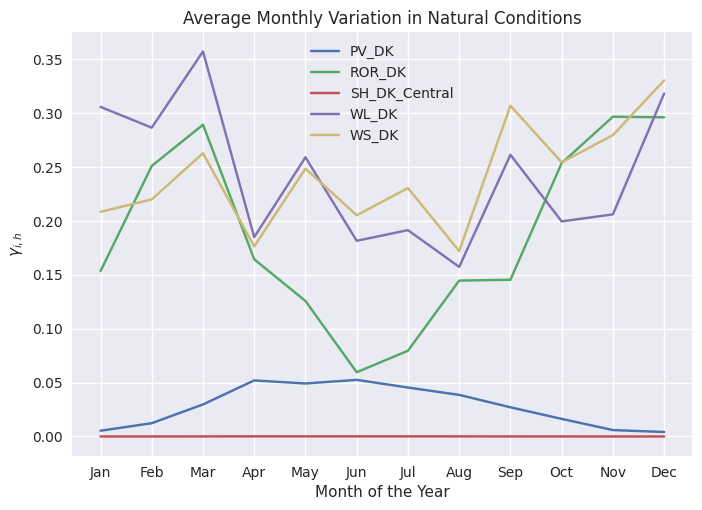

In [17]:
range_names = [0, 1, 2, 4, 5]
plants_names_intermit = db['CapVariation'].index.levels[1][range_names]

month = adj.rc_pd(m.db['h2Month'], name= 'Month')

for n, i in enumerate(plants_names_intermit):
    adjMultiIndex.applyMult(db['CapVariation'], month).loc[:,i].mean(level=['Month']).plot(label= plants_names_intermit[n])

months= ['Jan', 'Feb', 'Mar', 'Apr','May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct','Nov', 'Dec']
plt.xticks(np.arange(start=1, stop=13, step=1), months)
plt.xlabel('Month of the Year')
plt.ylabel('$\gamma_{i,h}$')
plt.title('Average Monthly Variation in Natural Conditions')
plt.legend()
plt.savefig('monthly_variation_natural_conditions_plot.png')

In [18]:
range_names = [0, 1, 2, 4, 5]
plants_names_intermit = db['CapVariation'].index.levels[1][range_names]

h2HourOfTheDay = adj.rc_pd(m.db['h2HourOfTheDay'], name= 'HourOfTheDay')

#for n, i in enumerate(plants_names_intermit):
#    adjMultiIndex.applyMult(db['CapVariation'], h2HourOfTheDay).loc[:,i].mean(level=['HourOfTheDay']).plot(label= plants_names_intermit[n])

hs2HourOfTheDay= np.arange(start=0, stop=24, step=1)
#plt.xticks(hs2HourOfTheDay,hs2HourOfTheDay)
#plt.ylabel('$\gamma_{i,h}$')
#plt.title('Average Hourly Variation in Natural Conditions')
#plt.legend()
#plt.savefig('hourly_variation_plot.png')

In [19]:
range_names = [2]
plants_names_intermit = db['CapVariation'].index.levels[1][range_names]

month = adj.rc_pd(m.db['h2Month'], name= 'Month')

#for n, i in enumerate(plants_names_intermit):
#    adjMultiIndex.applyMult(db['CapVariation'], month).loc[:,i].mean(level=['Month']).plot(label= plants_names_intermit[n])

months= ['Jan', 'Feb', 'Mar', 'Apr','May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct','Nov', 'Dec']
#plt.xticks(np.arange(start=1, stop=13, step=1), months)
#plt.ylabel('$\gamma_{i,h}$')
#plt.title('Monthly Variation in Natural Conditions')
#plt.legend()
#plt.savefig('monthly_variation_SH_plot.png')

findfont: Font family 'Palatino Linotype' not found.
findfont: Font family 'Palatino Linotype' not found.
findfont: Font family 'Palatino Linotype' not found.
findfont: Font family 'Palatino Linotype' not found.
findfont: Font family 'Palatino Linotype' not found.
findfont: Font family 'Palatino Linotype' not found.
findfont: Font family 'Palatino Linotype' not found.
findfont: Font family 'Palatino Linotype' not found.
findfont: Font family 'Palatino Linotype' not found.
findfont: Font family 'Palatino Linotype' not found.
findfont: Font family 'Palatino Linotype' not found.
findfont: Font family 'Palatino Linotype' not found.
findfont: Font family 'Palatino Linotype' not found.
findfont: Font family 'Palatino Linotype' not found.
findfont: Font family 'Palatino Linotype' not found.
findfont: Font family 'Palatino Linotype' not found.
findfont: Font family 'Palatino Linotype' not found.
findfont: Font family 'Palatino Linotype' not found.
findfont: Font family 'Palatino Linotype' not 

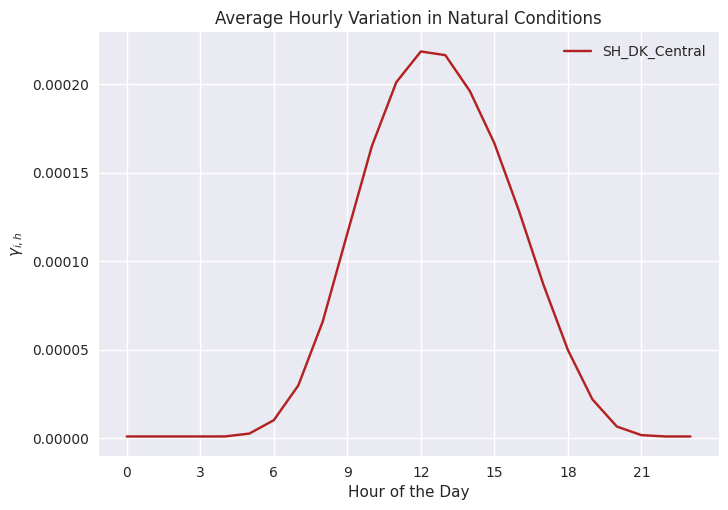

In [20]:
range_names = [2]
plants_names_intermit = db['CapVariation'].index.levels[1][range_names]

h2HourOfTheDay = adj.rc_pd(m.db['h2HourOfTheDay'], name= 'HourOfTheDay')

for n, i in enumerate(plants_names_intermit):
    adjMultiIndex.applyMult(db['CapVariation'], h2HourOfTheDay).loc[:,i].mean(level=['HourOfTheDay']).plot(label= plants_names_intermit[n], color='firebrick')

hs2HourOfTheDay= np.arange(start=0, stop=23, step=3)
plt.xticks(hs2HourOfTheDay,hs2HourOfTheDay)
plt.xlabel('Hour of the Day')
plt.ylabel('$\gamma_{i,h}$')
plt.title('Average Hourly Variation in Natural Conditions')
plt.legend()
plt.savefig('hourly_variation_SH_plot.png')

#### Heat Generation

In [21]:
#GenH_platn_names = base_db['Generation_H'].index.levels[2]

#month = adj.rc_pd(base_db['h2Month'], name= 'Month')



#for n, i in enumerate(GenH_platn_names):
#    adjMultiIndex.applyMult(base_db['Generation_H'], month).reset_index(level=['g_H'], drop=True).loc[:,i].mean(level=['Month']).plot(label= GenH_platn_names[n])

#months= ['Jan', 'Feb', 'Mar', 'Apr','May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct','Nov', 'Dec']
#plt.xticks(np.arange(start=1, stop=13, step=1), months)
#plt.ylabel('MWh')
#plt.title('Heat Generation')
#plt.legend()

In [22]:
GenH_plant_names = base_db['Generation_H'].index.levels[2]

hvt = adj.rc_pd(base_db['id2hvt'], name= 'HVT')

GenH_2_hvt = adjMultiIndex.applyMult(base_db['Generation_H'], hvt).reset_index(level=['g_H'], drop=True)

month = adj.rc_pd(base_db['h2Month'], name= 'Month')

range_xyz = [2,3]
hvt_plant_names = base_db['id2hvt'].levels[1][range_xyz]

#for n, i in enumerate(hvt_plant_names):
#    adjMultiIndex.applyMult(GenH_2_hvt, month).reset_index(level=['id'], drop=True).loc[:,i].mean(level=['Month']).plot(label= hvt_plant_names[n])

months= ['Jan', 'Feb', 'Mar', 'Apr','May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct','Nov', 'Dec']
#plt.xticks(np.arange(start=1, stop=13, step=1), months)
#plt.ylabel('MWh')
#plt.title('Intermittent Heat Generation')
#plt.legend()

In [23]:
GenH_plant_names = base_db['Generation_H'].index.levels[2]

id2tech = adj.rc_pd(base_db['id2tech'], name = 'id2tech')
GenH_id2tech = adjMultiIndex.applyMult(base_db['Generation_H'], id2tech).reset_index(level=['g_H'], drop=True)

tech2modelTech = adj.rc_pd(base_db['tech2modelTech'], name = 'tech2modelTech')
GenH_id2tech_tech2modelTech = adjMultiIndex.applyMult(GenH_id2tech, tech2modelTech)

range_tech2modelTec = [2]
names = GenH_id2tech_tech2modelTech.index.levels[3]

month = adj.rc_pd(base_db['h2Month'], name= 'Month')

#for n, i in enumerate(names):
#    adjMultiIndex.applyMult(GenH_id2tech_tech2modelTech, month).reset_index(level=['id','tech'], drop=True).loc[:,i].mean(level=['Month']).plot(label= names[n])

months= ['Jan', 'Feb', 'Mar', 'Apr','May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct','Nov', 'Dec']
#plt.xticks(np.arange(start=1, stop=13, step=1), months)
#plt.ylabel('MWh')
#plt.title('Intermittent Heat Generation')
#plt.legend()

Text(0.5, 1.0, 'Heat Pump - Heat Generation')

findfont: Font family 'Palatino Linotype' not found.
findfont: Font family 'Palatino Linotype' not found.
findfont: Font family 'Palatino Linotype' not found.
findfont: Font family 'Palatino Linotype' not found.
findfont: Font family 'Palatino Linotype' not found.
findfont: Font family 'Palatino Linotype' not found.
findfont: Font family 'Palatino Linotype' not found.
findfont: Font family 'Palatino Linotype' not found.
findfont: Font family 'Palatino Linotype' not found.
findfont: Font family 'Palatino Linotype' not found.
findfont: Font family 'Palatino Linotype' not found.
findfont: Font family 'Palatino Linotype' not found.
findfont: Font family 'Palatino Linotype' not found.
findfont: Font family 'Palatino Linotype' not found.
findfont: Font family 'Palatino Linotype' not found.
findfont: Font family 'Palatino Linotype' not found.
findfont: Font family 'Palatino Linotype' not found.
findfont: Font family 'Palatino Linotype' not found.
findfont: Font family 'Palatino Linotype' not 

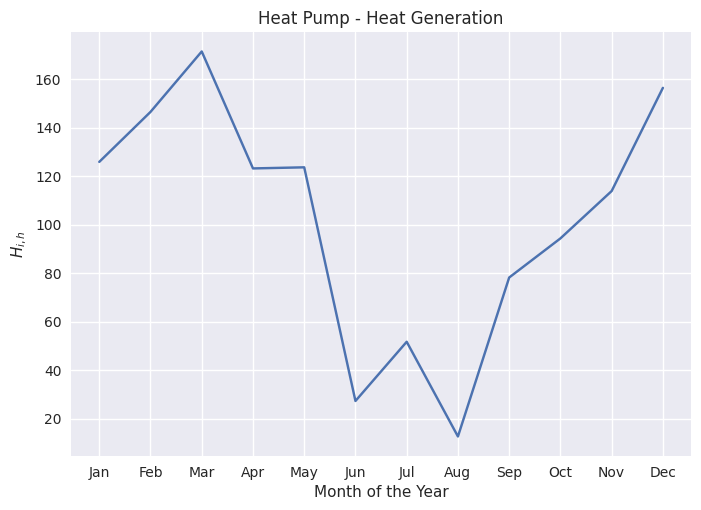

In [24]:
GenH_plant_names = base_db['Generation_H'].index.levels[2]

id2tech = adj.rc_pd(base_db['id2tech'], name = 'id2tech')
GenH_id2tech = adjMultiIndex.applyMult(base_db['Generation_H'], id2tech).reset_index(level=['g_H'], drop=True)

tech2modelTech = adj.rc_pd(base_db['tech2modelTech'], name = 'tech2modelTech')
GenH_id2tech_tech2modelTech = adjMultiIndex.applyMult(GenH_id2tech, tech2modelTech)

range_tech2modelTec = [2]
names = GenH_id2tech_tech2modelTech.index.levels[3][range_tech2modelTec]

month = adj.rc_pd(base_db['h2Month'], name= 'Month')

for n, i in enumerate(names):
    adjMultiIndex.applyMult(GenH_id2tech_tech2modelTech, month).reset_index(level=['id','tech'], drop=True).loc[:,i].mean(level=['Month']).plot()

months= ['Jan', 'Feb', 'Mar', 'Apr','May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct','Nov', 'Dec']
plt.xticks(np.arange(start=1, stop=13, step=1), months)
plt.ylabel('$H_{i,h}$')
plt.xlabel('Month of the Year')
plt.title('Heat Pump - Heat Generation')
#plt.savefig('baseline_monthly_generation_H_HP_plot.png')

Text(0.5, 1.0, 'Solar Heat - Heat Generation')

findfont: Font family 'Palatino Linotype' not found.
findfont: Font family 'Palatino Linotype' not found.
findfont: Font family 'Palatino Linotype' not found.
findfont: Font family 'Palatino Linotype' not found.
findfont: Font family 'Palatino Linotype' not found.
findfont: Font family 'Palatino Linotype' not found.
findfont: Font family 'Palatino Linotype' not found.
findfont: Font family 'Palatino Linotype' not found.
findfont: Font family 'Palatino Linotype' not found.
findfont: Font family 'Palatino Linotype' not found.
findfont: Font family 'Palatino Linotype' not found.
findfont: Font family 'Palatino Linotype' not found.
findfont: Font family 'Palatino Linotype' not found.
findfont: Font family 'Palatino Linotype' not found.
findfont: Font family 'Palatino Linotype' not found.
findfont: Font family 'Palatino Linotype' not found.
findfont: Font family 'Palatino Linotype' not found.
findfont: Font family 'Palatino Linotype' not found.
findfont: Font family 'Palatino Linotype' not 

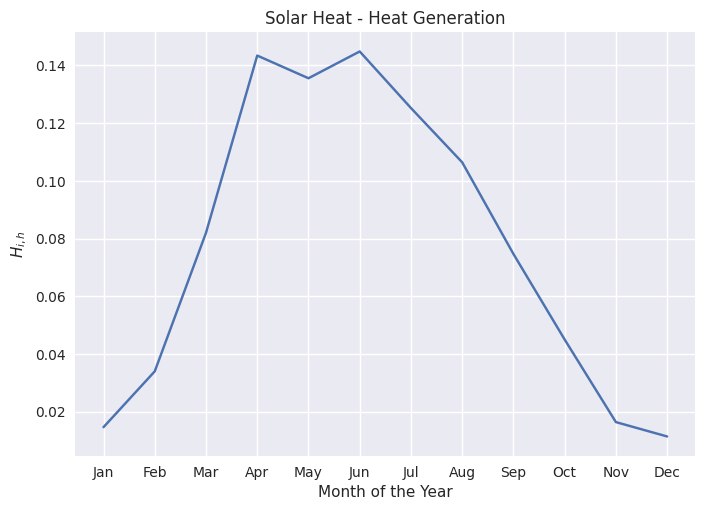

In [25]:
id2tech = adj.rc_pd(base_db['id2tech'], name = 'id2tech')
GenH_id2tech = adjMultiIndex.applyMult(base_db['Generation_H'], id2tech).reset_index(level=['g_H'], drop=True)

range_id2tech = [21]
names_id2tech = GenH_id2tech.index.levels[2][range_id2tech]

month = adj.rc_pd(base_db['h2Month'], name= 'Month')

for n, i in enumerate(names_id2tech):
    adjMultiIndex.applyMult(GenH_id2tech, month).reset_index(level=['id'], drop=True).loc[:,i].mean(level=['Month']).plot()

months= ['Jan', 'Feb', 'Mar', 'Apr','May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct','Nov', 'Dec']
plt.xticks(np.arange(start=1, stop=13, step=1), months)
plt.ylabel('$H_{i,h}$')
plt.xlabel('Month of the Year')
plt.title('Solar Heat - Heat Generation')
#plt.savefig('baseline_monthly_generation_H_SH_plot.png')

In [26]:
#month = adj.rc_pd(m.db['h2Month'], name= 'Month')

#adjMultiIndex.applyMult(base_db['Generation_H'], month).sum(level=['Month']).plot(legend=False)

#months= ['Jan', 'Feb', 'Mar', 'Apr','May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct','Nov', 'Dec']
#plt.xticks(np.arange(start=1, stop=13, step=1), months)
#plt.ylabel('MWh')
#plt.title('Total Heat Generation')

#### Electricity Generation

findfont: Font family 'Palatino Linotype' not found.
findfont: Font family 'Palatino Linotype' not found.
findfont: Font family 'Palatino Linotype' not found.
findfont: Font family 'Palatino Linotype' not found.
findfont: Font family 'Palatino Linotype' not found.
findfont: Font family 'Palatino Linotype' not found.
findfont: Font family 'Palatino Linotype' not found.
findfont: Font family 'Palatino Linotype' not found.
findfont: Font family 'Palatino Linotype' not found.
findfont: Font family 'Palatino Linotype' not found.
findfont: Font family 'Palatino Linotype' not found.
findfont: Font family 'Palatino Linotype' not found.
findfont: Font family 'Palatino Linotype' not found.
findfont: Font family 'Palatino Linotype' not found.
findfont: Font family 'Palatino Linotype' not found.
findfont: Font family 'Palatino Linotype' not found.
findfont: Font family 'Palatino Linotype' not found.
findfont: Font family 'Palatino Linotype' not found.
findfont: Font family 'Palatino Linotype' not 

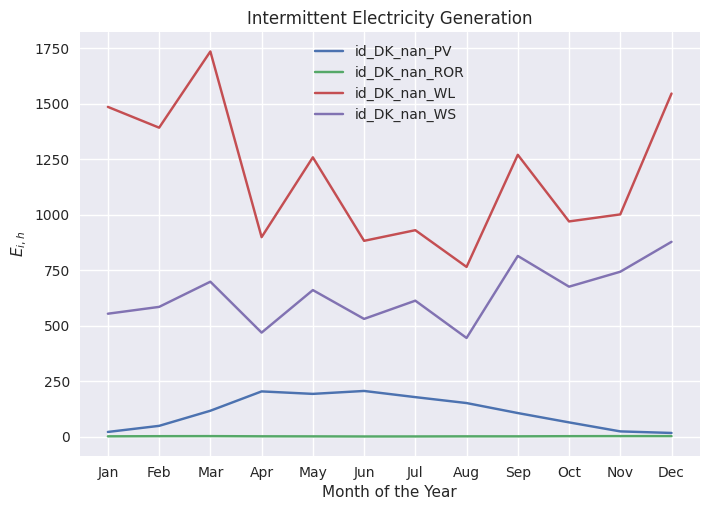

In [27]:
range_E = [18,19,20,21]
plants_names_intermit_E = base_db['Generation_E'].index.levels[2][range_E]

month = adj.rc_pd(m.db['h2Month'], name= 'Month')

for n, i in enumerate(plants_names_intermit_E):
    adjMultiIndex.applyMult(base_db['Generation_E'], month).reset_index(level=['g_E'], drop=True).loc[:,i].mean(level=['Month']).plot(label= plants_names_intermit_E[n])

months= ['Jan', 'Feb', 'Mar', 'Apr','May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct','Nov', 'Dec']
plt.xticks(np.arange(start=1, stop=13, step=1), months)
plt.xlabel('Month of the Year')
plt.ylabel('$E_{i,h}$')
plt.title('Intermittent Electricity Generation')
plt.legend()
#plt.savefig('baseline_monthly_generation_E_intermittent_plot.png')

#### Marginal System Costs H

findfont: Font family 'Palatino Linotype' not found.
findfont: Font family 'Palatino Linotype' not found.
findfont: Font family 'Palatino Linotype' not found.
findfont: Font family 'Palatino Linotype' not found.
findfont: Font family 'Palatino Linotype' not found.
findfont: Font family 'Palatino Linotype' not found.
findfont: Font family 'Palatino Linotype' not found.
findfont: Font family 'Palatino Linotype' not found.
findfont: Font family 'Palatino Linotype' not found.
findfont: Font family 'Palatino Linotype' not found.
findfont: Font family 'Palatino Linotype' not found.
findfont: Font family 'Palatino Linotype' not found.
findfont: Font family 'Palatino Linotype' not found.
findfont: Font family 'Palatino Linotype' not found.
findfont: Font family 'Palatino Linotype' not found.
findfont: Font family 'Palatino Linotype' not found.
findfont: Font family 'Palatino Linotype' not found.
findfont: Font family 'Palatino Linotype' not found.
findfont: Font family 'Palatino Linotype' not 

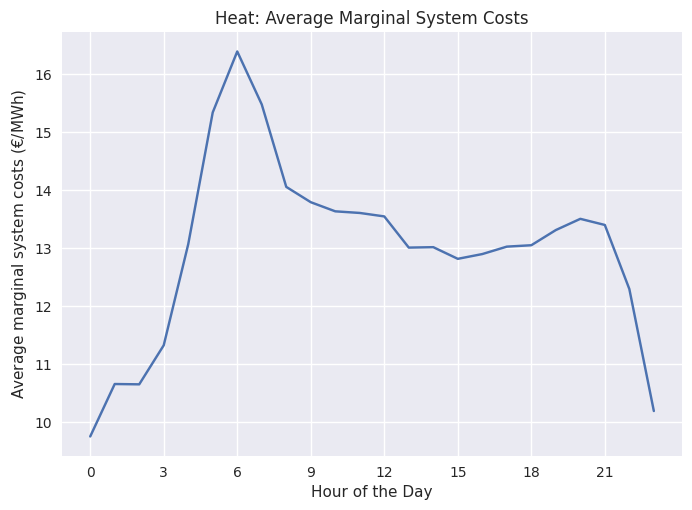

In [28]:
# Save as df
marginalSystemCosts_H_df = base_db['marginalSystemCosts_H'].to_frame().reset_index().rename(columns={0: 'MarginalSystemCosts'})

# Add hour mapping to df
marginalSystemCosts_H_df = marginalSystemCosts_H_df.reset_index().merge(m.db['h2HourOfTheDay'].to_frame(index=False))

#tick_positions = range(0, 8761, 1000)

# Plot the subset DataFrame
marginalSystemCosts_H_df.groupby('HourOfTheDay')['MarginalSystemCosts'].mean().plot()

hs2HourOfTheDay= np.arange(start=0, stop=23, step=3)
plt.xticks(hs2HourOfTheDay,hs2HourOfTheDay)

plt.xlabel('Hour of the Day')
plt.ylabel('Average marginal system costs ($€/$MWh)')
plt.title('Heat: Average Marginal System Costs')
plt.savefig('baseline_hourly_systemcosts_H_plot.png')
plt.show()

In [29]:
# Save as df
#marginalSystemCosts_H_df = base_db['marginalSystemCosts_H'].to_frame().reset_index().rename(columns={0: 'MarginalSystemCosts'})

# Add hour mapping to df
#marginalSystemCosts_H_df = marginalSystemCosts_H_df.reset_index().merge(m.db['h2Day'].to_frame(index=False))

#tick_positions = range(0, 8761, 1000)

# Plot the subset DataFrame
#marginalSystemCosts_H_df.groupby('Day')['MarginalSystemCosts'].mean().plot()
#plt.xlabel('Day of the Year')
#plt.ylabel('Average marginal system costs ($€/$MWh)')
#plt.title('Heat: Average Marginal System Costs')
#plt.show()

findfont: Font family 'Palatino Linotype' not found.
findfont: Font family 'Palatino Linotype' not found.
findfont: Font family 'Palatino Linotype' not found.
findfont: Font family 'Palatino Linotype' not found.
findfont: Font family 'Palatino Linotype' not found.
findfont: Font family 'Palatino Linotype' not found.
findfont: Font family 'Palatino Linotype' not found.
findfont: Font family 'Palatino Linotype' not found.
findfont: Font family 'Palatino Linotype' not found.
findfont: Font family 'Palatino Linotype' not found.
findfont: Font family 'Palatino Linotype' not found.
findfont: Font family 'Palatino Linotype' not found.
findfont: Font family 'Palatino Linotype' not found.
findfont: Font family 'Palatino Linotype' not found.
findfont: Font family 'Palatino Linotype' not found.
findfont: Font family 'Palatino Linotype' not found.
findfont: Font family 'Palatino Linotype' not found.
findfont: Font family 'Palatino Linotype' not found.
findfont: Font family 'Palatino Linotype' not 

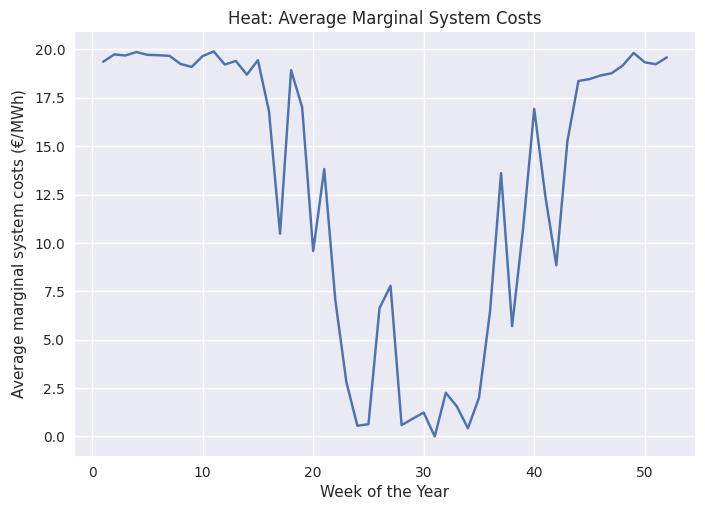

In [30]:
# Save as df
marginalSystemCosts_H_df = base_db['marginalSystemCosts_H'].to_frame().reset_index().rename(columns={0: 'MarginalSystemCosts'})

# Add hour mapping to df
marginalSystemCosts_H_df = marginalSystemCosts_H_df.reset_index().merge(m.db['h2Week'].to_frame(index=False))

#tick_positions = range(0, 8761, 1000)

# Plot the subset DataFrame
marginalSystemCosts_H_df.groupby('Week')['MarginalSystemCosts'].mean().plot()
plt.xlabel('Week of the Year')
plt.ylabel('Average marginal system costs ($€/$MWh)')
plt.title('Heat: Average Marginal System Costs')
plt.savefig('baseline_weekly_systemcosts_H_plot.png')
plt.show()

#### Storage Technology

findfont: Font family 'Palatino Linotype' not found.
findfont: Font family 'Palatino Linotype' not found.
findfont: Font family 'Palatino Linotype' not found.
findfont: Font family 'Palatino Linotype' not found.
findfont: Font family 'Palatino Linotype' not found.
findfont: Font family 'Palatino Linotype' not found.
findfont: Font family 'Palatino Linotype' not found.
findfont: Font family 'Palatino Linotype' not found.
findfont: Font family 'Palatino Linotype' not found.
findfont: Font family 'Palatino Linotype' not found.
findfont: Font family 'Palatino Linotype' not found.
findfont: Font family 'Palatino Linotype' not found.
findfont: Font family 'Palatino Linotype' not found.
findfont: Font family 'Palatino Linotype' not found.
findfont: Font family 'Palatino Linotype' not found.
findfont: Font family 'Palatino Linotype' not found.
findfont: Font family 'Palatino Linotype' not found.
findfont: Font family 'Palatino Linotype' not found.
findfont: Font family 'Palatino Linotype' not 

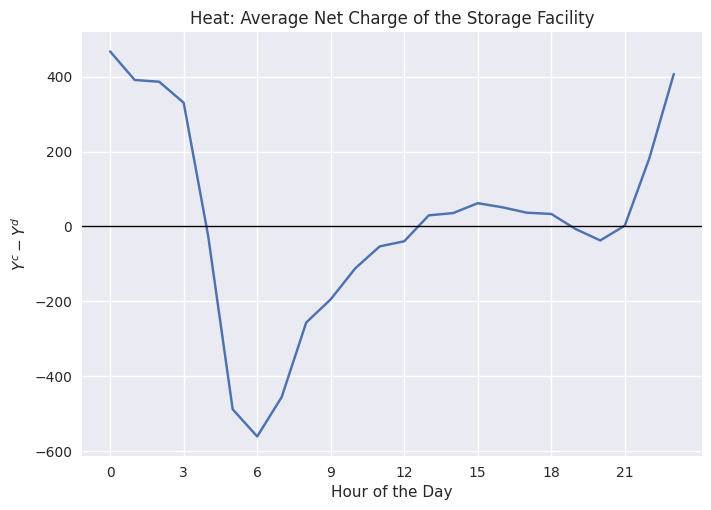

In [31]:
# Make dataframe
charge = (base_db['charge_H'].droplevel('id')).to_frame(name='charge')
discharge = (base_db['discharge_H'].droplevel('id')).to_frame(name='discharge')

df_Y = pd.concat([charge, discharge], axis=0).groupby('h').agg('sum')
df_Y['result_column'] = df_Y['charge'] - df_Y['discharge']

# Make new dataframe with time mappings
df = df_Y['result_column'].reset_index().merge(base_db['h2HourOfTheDay'].to_frame(index=False))
df = df.drop(columns=['h'])

# Make plot
fig, ax = plt.subplots()
df.groupby('HourOfTheDay').mean().plot(xlabel='Hour of the Day', ylabel=r'$Y^c - Y^d$', ax=ax, legend=False)
hs2HourOfTheDay= np.arange(start=0, stop=23, step=3)
ax.axhline(y=0, color='black', linewidth=1, linestyle='-')
plt.xticks(hs2HourOfTheDay,hs2HourOfTheDay)
plt.title('Heat: Average Net Charge of the Storage Facility')
plt.savefig('baseline_hourly_net_charge_H_plot.png')
plt.show()


In [32]:
# Save as df
charge_df = base_db['charge_H'].to_frame().reset_index().rename(columns={0: 'charge'})

# Add hour mapping to df
charge_df = charge_df.reset_index().merge(m.db['h2HourOfTheDay'].to_frame(index=False))

#tick_positions = range(0, 8761, 1000)

# Plot the subset DataFrame
#charge_df.groupby('HourOfTheDay')['charge'].mean().plot()
#plt.xlabel('Average hour of the day')
#plt.ylabel('Average charging (MW)')
#plt.xticks(tick_positions, tick_positions)
#plt.title('Average charging')
#plt.show()

In [33]:
# Save as df
discharge_df = base_db['discharge_H'].to_frame().reset_index().rename(columns={0: 'discharge'})

# Add hour mapping to df
discharge_df = discharge_df.reset_index().merge(m.db['h2HourOfTheDay'].to_frame(index=False))

#tick_positions = range(0, 8761, 1000)

# Plot the subset DataFrame
#discharge_df.groupby('HourOfTheDay')['discharge'].mean().plot()
#plt.xlabel('Average hour of the day')
#plt.ylabel('Average discharging (MW)')
#plt.xticks(tick_positions, tick_positions)
#plt.title('Average discharging')
#plt.show()

## Counterfactual Scenarios

### Solving

In the following, we will run an experiment where we are exogenously increase the capacity of the storage technology from the baseline levels. We exogenously take the size of the large hot water tank recently built in Germany ([Vattenfall's press release](https://group.vattenfall.com/press-and-media/newsroom/2022/germanys-largest-heat-storage-in-the-starting-blocks)) as the maximum size of our counterfactual scenarios. The tank has a size of 56'000 $m^3$. We then exogenously insert this number in cell *C30* in the file *\EnergyEconGroupWork\DownloadDataForDK\ModelData\technology_datasheet_for_energy_storage.xlsx* in sheet *141 Large hot water tank Berlin* to get the maximum values for $GeneratingCap\_H$, $chargeCap\_H$ and $sCap$. Note that we keep the energy to heat ratio constant at 60 hours (the time it takes to fully load or deload the tank).

We will also be extracting the following variables:

In [34]:
extract = ['marginalSystemCosts_H','charge_H','discharge_H','Welfare', 'marginalEconomicValue', 'λ_stored_H','λ_discharge_H','λ_charge_H','meanConsumerPrice_H','meanConsumerPrice_E']

In [55]:
# Setting
#E2H = 60.344828 # The "energy storage to heat"-ratio/storage duration
#maxcap = 53.8
loop = pd.Index(range(5), name = 'loop')
v0_GCap = pd.Series(base_db['GeneratingCap_H'], index = getTechs(['HS'],m.db))
vT_GCap = pd.Series(1678.8, index = v0_GCap.index)
v0_SCap = pd.Series(base_db['sCap'], index = getTechs(['HS'],m.db))
vT_SCap = pd.Series(100725, index = v0_GCap.index)

grid_GCap = adjMultiIndex.addGrid(v0_GCap,vT_GCap,loop,'GeneratingCapacity').astype(int)
grid_SCap = adjMultiIndex.addGrid(v0_SCap,vT_SCap,loop,'sCap').astype(int)

In [56]:
base_db['sCap']

id
id_DK_Central_HS    50365.0
Name: sCap, dtype: float64

In [57]:
grid_GCap

loop  id              
0     id_DK_Central_HS     839
1     id_DK_Central_HS    1049
2     id_DK_Central_HS    1259
3     id_DK_Central_HS    1468
4     id_DK_Central_HS    1678
Name: GeneratingCapacity, dtype: int64

In [58]:
grid_SCap

loop  id              
0     id_DK_Central_HS     50365
1     id_DK_Central_HS     62955
2     id_DK_Central_HS     75545
3     id_DK_Central_HS     88135
4     id_DK_Central_HS    100725
Name: sCap, dtype: int64

We now run the counterfactual scenarios:

In [59]:
solution = m.loopSolveExtract(loop, [grid_GCap, grid_SCap], extract)

### Plotting:

#### Marginal System Costs H

In [60]:
loop_id=loop[[0,1,2,3,4]]

findfont: Font family 'Palatino Linotype' not found.
findfont: Font family 'Palatino Linotype' not found.
findfont: Font family 'Palatino Linotype' not found.
findfont: Font family 'Palatino Linotype' not found.
findfont: Font family 'Palatino Linotype' not found.
findfont: Font family 'Palatino Linotype' not found.
findfont: Font family 'Palatino Linotype' not found.
findfont: Font family 'Palatino Linotype' not found.
findfont: Font family 'Palatino Linotype' not found.
findfont: Font family 'Palatino Linotype' not found.
findfont: Font family 'Palatino Linotype' not found.
findfont: Font family 'Palatino Linotype' not found.
findfont: Font family 'Palatino Linotype' not found.
findfont: Font family 'Palatino Linotype' not found.
findfont: Font family 'Palatino Linotype' not found.
findfont: Font family 'Palatino Linotype' not found.
findfont: Font family 'Palatino Linotype' not found.
findfont: Font family 'Palatino Linotype' not found.
findfont: Font family 'Palatino Linotype' not 

findfont: Font family 'Palatino Linotype' not found.
findfont: Font family 'Palatino Linotype' not found.
findfont: Font family 'Palatino Linotype' not found.
findfont: Font family 'Palatino Linotype' not found.
findfont: Font family 'Palatino Linotype' not found.
findfont: Font family 'Palatino Linotype' not found.
findfont: Font family 'Palatino Linotype' not found.
findfont: Font family 'Palatino Linotype' not found.
findfont: Font family 'Palatino Linotype' not found.
findfont: Font family 'Palatino Linotype' not found.
findfont: Font family 'Palatino Linotype' not found.
findfont: Font family 'Palatino Linotype' not found.
findfont: Font family 'Palatino Linotype' not found.
findfont: Font family 'Palatino Linotype' not found.
findfont: Font family 'Palatino Linotype' not found.
findfont: Font family 'Palatino Linotype' not found.
findfont: Font family 'Palatino Linotype' not found.
findfont: Font family 'Palatino Linotype' not found.
findfont: Font family 'Palatino Linotype' not 

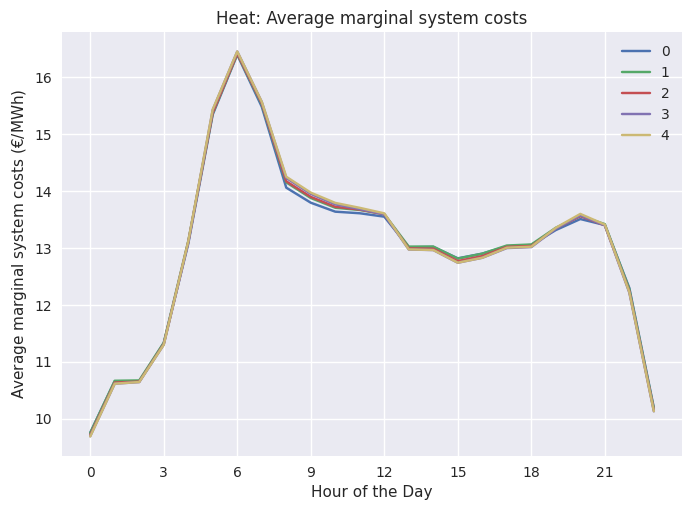

In [61]:
# Add hour mapping to df
marginalSystemCosts_H_df_loop = adj.rc_pd(solution['marginalSystemCosts_H'],loop_id).unstack('loop').reset_index().merge(m.db['h2HourOfTheDay'].to_frame(index=False))

# Deleta h column as it messes up plotting
marginalSystemCosts_H_df_loop = marginalSystemCosts_H_df_loop.drop('h', axis=1)

# Plot the subset Series
marginalSystemCosts_H_df_loop.groupby('HourOfTheDay').mean().plot()

hs2HourOfTheDay= np.arange(start=0, stop=23, step=3)
plt.xticks(hs2HourOfTheDay,hs2HourOfTheDay)

plt.xlabel('Hour of the Day')
plt.ylabel('Average marginal system costs ($€/$MWh)')
plt.title('Heat: Average marginal system costs')
plt.savefig('counterfactual_hourly_systemcosts_H_plot.png')
plt.show()

findfont: Font family 'Palatino Linotype' not found.
findfont: Font family 'Palatino Linotype' not found.
findfont: Font family 'Palatino Linotype' not found.
findfont: Font family 'Palatino Linotype' not found.
findfont: Font family 'Palatino Linotype' not found.


findfont: Font family 'Palatino Linotype' not found.
findfont: Font family 'Palatino Linotype' not found.
findfont: Font family 'Palatino Linotype' not found.
findfont: Font family 'Palatino Linotype' not found.
findfont: Font family 'Palatino Linotype' not found.
findfont: Font family 'Palatino Linotype' not found.
findfont: Font family 'Palatino Linotype' not found.
findfont: Font family 'Palatino Linotype' not found.
findfont: Font family 'Palatino Linotype' not found.
findfont: Font family 'Palatino Linotype' not found.
findfont: Font family 'Palatino Linotype' not found.
findfont: Font family 'Palatino Linotype' not found.
findfont: Font family 'Palatino Linotype' not found.
findfont: Font family 'Palatino Linotype' not found.
findfont: Font family 'Palatino Linotype' not found.
findfont: Font family 'Palatino Linotype' not found.
findfont: Font family 'Palatino Linotype' not found.
findfont: Font family 'Palatino Linotype' not found.
findfont: Font family 'Palatino Linotype' not 

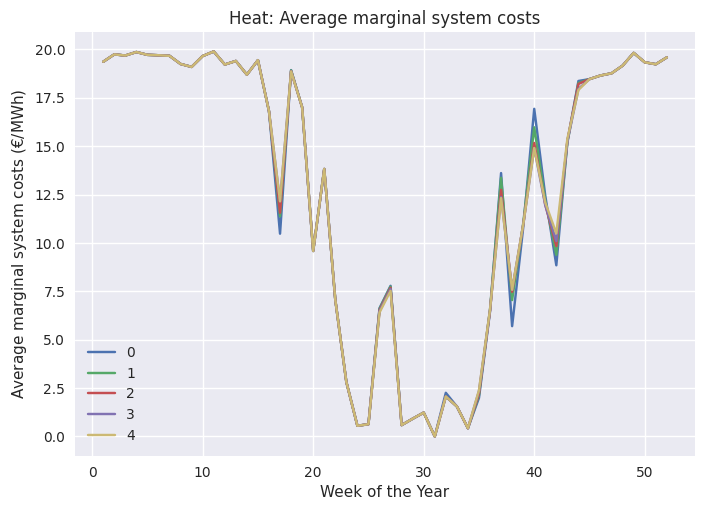

In [62]:
# Add hour mapping to df
marginalSystemCosts_H_df_loop_week = adj.rc_pd(solution['marginalSystemCosts_H'],loop_id).unstack('loop').reset_index().merge(m.db['h2Week'].to_frame(index=False))

# Deleta h column as it messes up plotting
marginalSystemCosts_H_df_loop_week = marginalSystemCosts_H_df_loop_week.drop('h', axis=1)

# Plot the subset Series
marginalSystemCosts_H_df_loop_week.groupby('Week').mean().plot()
plt.xlabel('Week of the Year')
plt.ylabel('Average marginal system costs ($€/$MWh)')
plt.title('Heat: Average marginal system costs')
plt.savefig('counterfactual_weekly_systemcosts_H_plot.png')
plt.show()

findfont: Font family 'Palatino Linotype' not found.
findfont: Font family 'Palatino Linotype' not found.
findfont: Font family 'Palatino Linotype' not found.
findfont: Font family 'Palatino Linotype' not found.
findfont: Font family 'Palatino Linotype' not found.
findfont: Font family 'Palatino Linotype' not found.
findfont: Font family 'Palatino Linotype' not found.
findfont: Font family 'Palatino Linotype' not found.
findfont: Font family 'Palatino Linotype' not found.
findfont: Font family 'Palatino Linotype' not found.
findfont: Font family 'Palatino Linotype' not found.
findfont: Font family 'Palatino Linotype' not found.
findfont: Font family 'Palatino Linotype' not found.
findfont: Font family 'Palatino Linotype' not found.
findfont: Font family 'Palatino Linotype' not found.
findfont: Font family 'Palatino Linotype' not found.
findfont: Font family 'Palatino Linotype' not found.
findfont: Font family 'Palatino Linotype' not found.
findfont: Font family 'Palatino Linotype' not 

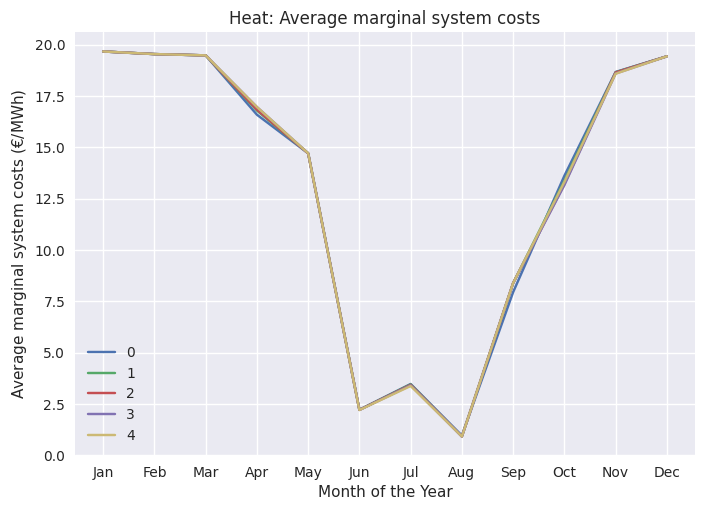

In [63]:
# Add hour mapping to df
marginalSystemCosts_H_df_loop_month = adj.rc_pd(solution['marginalSystemCosts_H'],loop_id).unstack('loop').reset_index().merge(m.db['h2Month'].to_frame(index=False))

# Deleta h column as it messes up plotting
marginalSystemCosts_H_df_loop_month = marginalSystemCosts_H_df_loop_month.drop('h', axis=1)

# Plot the subset Series
marginalSystemCosts_H_df_loop_month.groupby('Month').mean().plot()
months= ['Jan', 'Feb', 'Mar', 'Apr','May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct','Nov', 'Dec']
plt.xticks(np.arange(start=1, stop=13, step=1), months)
plt.xlabel('Month of the Year')
plt.ylabel('Average marginal system costs ($€/$MWh)')
plt.title('Heat: Average marginal system costs')
#plt.savefig('counterfactual_monthly_systemcosts_H_plot.png')
plt.show()

#### Mean Consumer Prices

findfont: Font family 'Palatino Linotype' not found.
findfont: Font family 'Palatino Linotype' not found.
findfont: Font family 'Palatino Linotype' not found.
findfont: Font family 'Palatino Linotype' not found.
findfont: Font family 'Palatino Linotype' not found.
findfont: Font family 'Palatino Linotype' not found.
findfont: Font family 'Palatino Linotype' not found.
findfont: Font family 'Palatino Linotype' not found.
findfont: Font family 'Palatino Linotype' not found.
findfont: Font family 'Palatino Linotype' not found.
findfont: Font family 'Palatino Linotype' not found.
findfont: Font family 'Palatino Linotype' not found.
findfont: Font family 'Palatino Linotype' not found.
findfont: Font family 'Palatino Linotype' not found.
findfont: Font family 'Palatino Linotype' not found.
findfont: Font family 'Palatino Linotype' not found.
findfont: Font family 'Palatino Linotype' not found.
findfont: Font family 'Palatino Linotype' not found.
findfont: Font family 'Palatino Linotype' not 

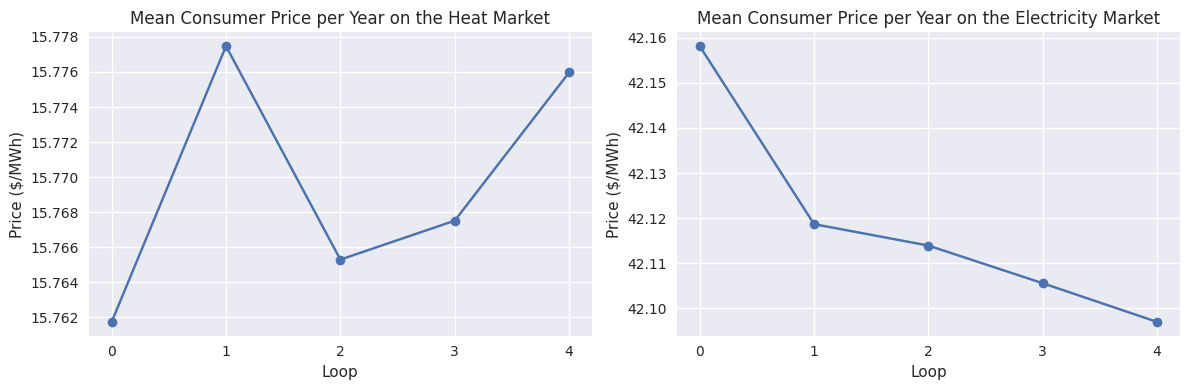

In [64]:
# Add hour mapping to df
meanConsumerPrice_H_df_loop = adj.rc_pd(solution['meanConsumerPrice_H'],loop_id).unstack('loop').reset_index()
meanConsumerPrice_E_df_loop = adj.rc_pd(solution['meanConsumerPrice_E'],loop_id).unstack('loop').reset_index()

# Delete some columns
meanConsumerPrice_H_df_loop = meanConsumerPrice_H_df_loop.drop(['g_H','c_H'], axis=1)
meanConsumerPrice_E_df_loop = meanConsumerPrice_E_df_loop.drop(['g_E','c_E'], axis=1)

# From wide to long
meanConsumerPrice_H_df_loop_long = pd.melt(meanConsumerPrice_H_df_loop, var_name='loop', value_name='meanConsumerPrice_H')
meanConsumerPrice_E_df_loop_long = pd.melt(meanConsumerPrice_E_df_loop, var_name='loop', value_name='meanConsumerPrice_E')

# Create subplots
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 4))

# Plot for Heat Market
ax1.plot(meanConsumerPrice_H_df_loop_long['loop'], meanConsumerPrice_H_df_loop_long['meanConsumerPrice_H'], marker='o', linestyle='-')
loops_xticks = np.arange(start=0, stop=5, step=1)
ax1.set_xticks(loops_xticks)
ax1.set_xlabel('Loop')
ax1.set_ylabel('Price ($/MWh)')
ax1.set_title('Mean Consumer Price per Year on the Heat Market')

# Plot for Electricity Market
ax2.plot(meanConsumerPrice_E_df_loop_long['loop'], meanConsumerPrice_E_df_loop_long['meanConsumerPrice_E'], marker='o', linestyle='-')
loops_xticks = np.arange(start=0, stop=5, step=1)
ax2.set_xticks(loops_xticks)
ax2.set_xlabel('Loop')
ax2.set_ylabel('Price ($/MWh)')
ax2.set_title('Mean Consumer Price per Year on the Electricity Market')

# Layout
plt.tight_layout()

# Save Figure
plt.savefig('counterfactual_meanConsumerPrices_plot.png')

# Show the plots
plt.show()

#### Storage Technology

findfont: Font family 'Palatino Linotype' not found.
findfont: Font family 'Palatino Linotype' not found.
findfont: Font family 'Palatino Linotype' not found.
findfont: Font family 'Palatino Linotype' not found.
findfont: Font family 'Palatino Linotype' not found.
findfont: Font family 'Palatino Linotype' not found.
findfont: Font family 'Palatino Linotype' not found.
findfont: Font family 'Palatino Linotype' not found.
findfont: Font family 'Palatino Linotype' not found.
findfont: Font family 'Palatino Linotype' not found.
findfont: Font family 'Palatino Linotype' not found.
findfont: Font family 'Palatino Linotype' not found.
findfont: Font family 'Palatino Linotype' not found.
findfont: Font family 'Palatino Linotype' not found.
findfont: Font family 'Palatino Linotype' not found.
findfont: Font family 'Palatino Linotype' not found.
findfont: Font family 'Palatino Linotype' not found.
findfont: Font family 'Palatino Linotype' not found.
findfont: Font family 'Palatino Linotype' not 

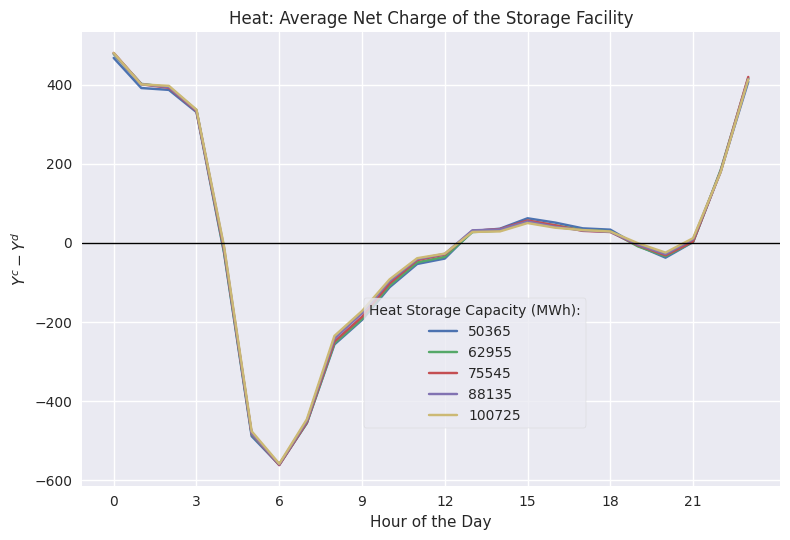

In [65]:
# Make dataframe
charge_H = adj.rc_pd(solution['charge_H'].droplevel('id'),loop_id).unstack('loop').rename_axis(None,axis=1)
discharge_H = adj.rc_pd(-solution['discharge_H'].droplevel('id'),loop_id).unstack('loop').rename_axis(None,axis=1)

df_Y =  pd.concat([charge_H,discharge_H],axis=0).groupby('h').agg('sum')

# Make new dataframe with time mappings
p_names = df_Y.columns.copy()
df = df_Y.reset_index().merge(m.db['h2HourOfTheDay'].to_frame(index=False))

# Make plot
fig, ax = plt.subplots()
df.groupby('HourOfTheDay')[p_names].mean().plot(xlabel='Hour of the Day',ylabel=r'$Y^c-Y^d$',ax=ax,legend=False)
fig.legend(grid_SCap[loop_id].tolist(),loc='lower center', frameon=True, bbox_to_anchor=(0.6,0.2),title=r'Heat Storage Capacity (MWh):')
hs2HourOfTheDay= np.arange(start=0, stop=23, step=3)
ax.axhline(y=0, color='black', linewidth=1, linestyle='-')
plt.xticks(hs2HourOfTheDay,hs2HourOfTheDay)
plt.title('Heat: Average Net Charge of the Storage Facility')
plt.savefig('counterfactual_hourly_net_charge_H_plot.png')
fig.tight_layout()

#### Marginal Economic Value of Stored Heat

#### Marginal Economic Value of Generators

In [66]:
import seaborn as sns

##### All Generators

findfont: Font family 'Palatino Linotype' not found.
findfont: Font family 'Palatino Linotype' not found.
findfont: Font family 'Palatino Linotype' not found.
findfont: Font family 'Palatino Linotype' not found.


findfont: Font family 'Palatino Linotype' not found.
findfont: Font family 'Palatino Linotype' not found.
findfont: Font family 'Palatino Linotype' not found.
findfont: Font family 'Palatino Linotype' not found.
findfont: Font family 'Palatino Linotype' not found.
findfont: Font family 'Palatino Linotype' not found.
findfont: Font family 'Palatino Linotype' not found.
findfont: Font family 'Palatino Linotype' not found.
findfont: Font family 'Palatino Linotype' not found.
findfont: Font family 'Palatino Linotype' not found.
findfont: Font family 'Palatino Linotype' not found.
findfont: Font family 'Palatino Linotype' not found.
findfont: Font family 'Palatino Linotype' not found.
findfont: Font family 'Palatino Linotype' not found.
findfont: Font family 'Palatino Linotype' not found.
findfont: Font family 'Palatino Linotype' not found.
findfont: Font family 'Palatino Linotype' not found.
findfont: Font family 'Palatino Linotype' not found.
findfont: Font family 'Palatino Linotype' not 

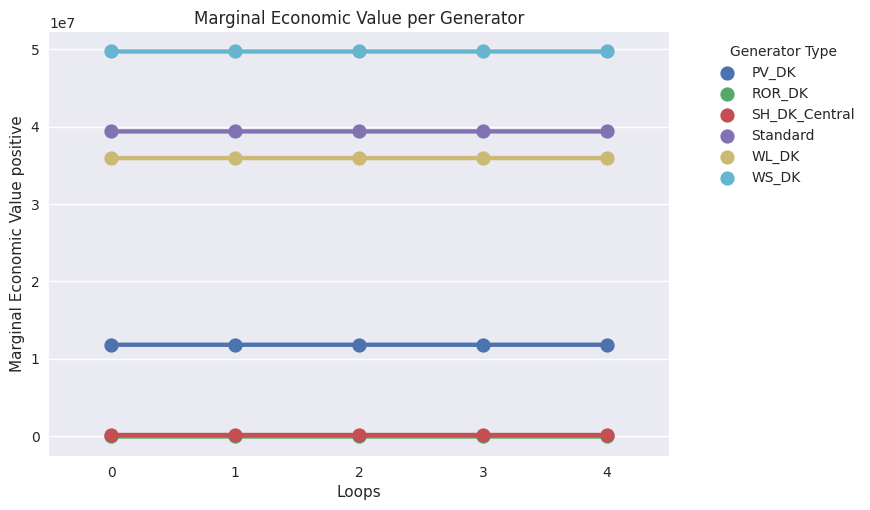

In [67]:
marginalEconomicValue_df_loop = adj.rc_pd(solution['marginalEconomicValue'],loop_id).unstack('loop').reset_index().merge(m.db['id2hvt'].to_frame(index=False))

# Plot the subset Series
marginalEconomicValue_df_loop_mean = marginalEconomicValue_df_loop.groupby('hvt').mean().reset_index()

# From wide to long
marginalEconomicValue_df_loop_mean_long = pd.melt(marginalEconomicValue_df_loop_mean,
                                                  id_vars=['hvt'],
                                                  value_vars=[0,1,2,3,4],
                                                  var_name='Loops',
                                                  value_name='Marginal Economic Value')

marginalEconomicValue_df_loop_mean_long['Marginal Economic Value positive'] = marginalEconomicValue_df_loop_mean_long['Marginal Economic Value']*(-1)

# Plot
sns.pointplot(x='Loops', y='Marginal Economic Value positive', hue='hvt', data=marginalEconomicValue_df_loop_mean_long, linestyles='-', dodge=False)
plt.title('Marginal Economic Value per Generator')

plt.legend(title='Generator Type', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.show()

##### Per Generator

findfont: Font family 'Palatino Linotype' not found.
findfont: Font family 'Palatino Linotype' not found.
findfont: Font family 'Palatino Linotype' not found.
findfont: Font family 'Palatino Linotype' not found.
findfont: Font family 'Palatino Linotype' not found.
findfont: Font family 'Palatino Linotype' not found.
findfont: Font family 'Palatino Linotype' not found.
findfont: Font family 'Palatino Linotype' not found.
findfont: Font family 'Palatino Linotype' not found.
findfont: Font family 'Palatino Linotype' not found.
findfont: Font family 'Palatino Linotype' not found.
findfont: Font family 'Palatino Linotype' not found.
findfont: Font family 'Palatino Linotype' not found.
findfont: Font family 'Palatino Linotype' not found.
findfont: Font family 'Palatino Linotype' not found.
findfont: Font family 'Palatino Linotype' not found.
findfont: Font family 'Palatino Linotype' not found.
findfont: Font family 'Palatino Linotype' not found.
findfont: Font family 'Palatino Linotype' not 

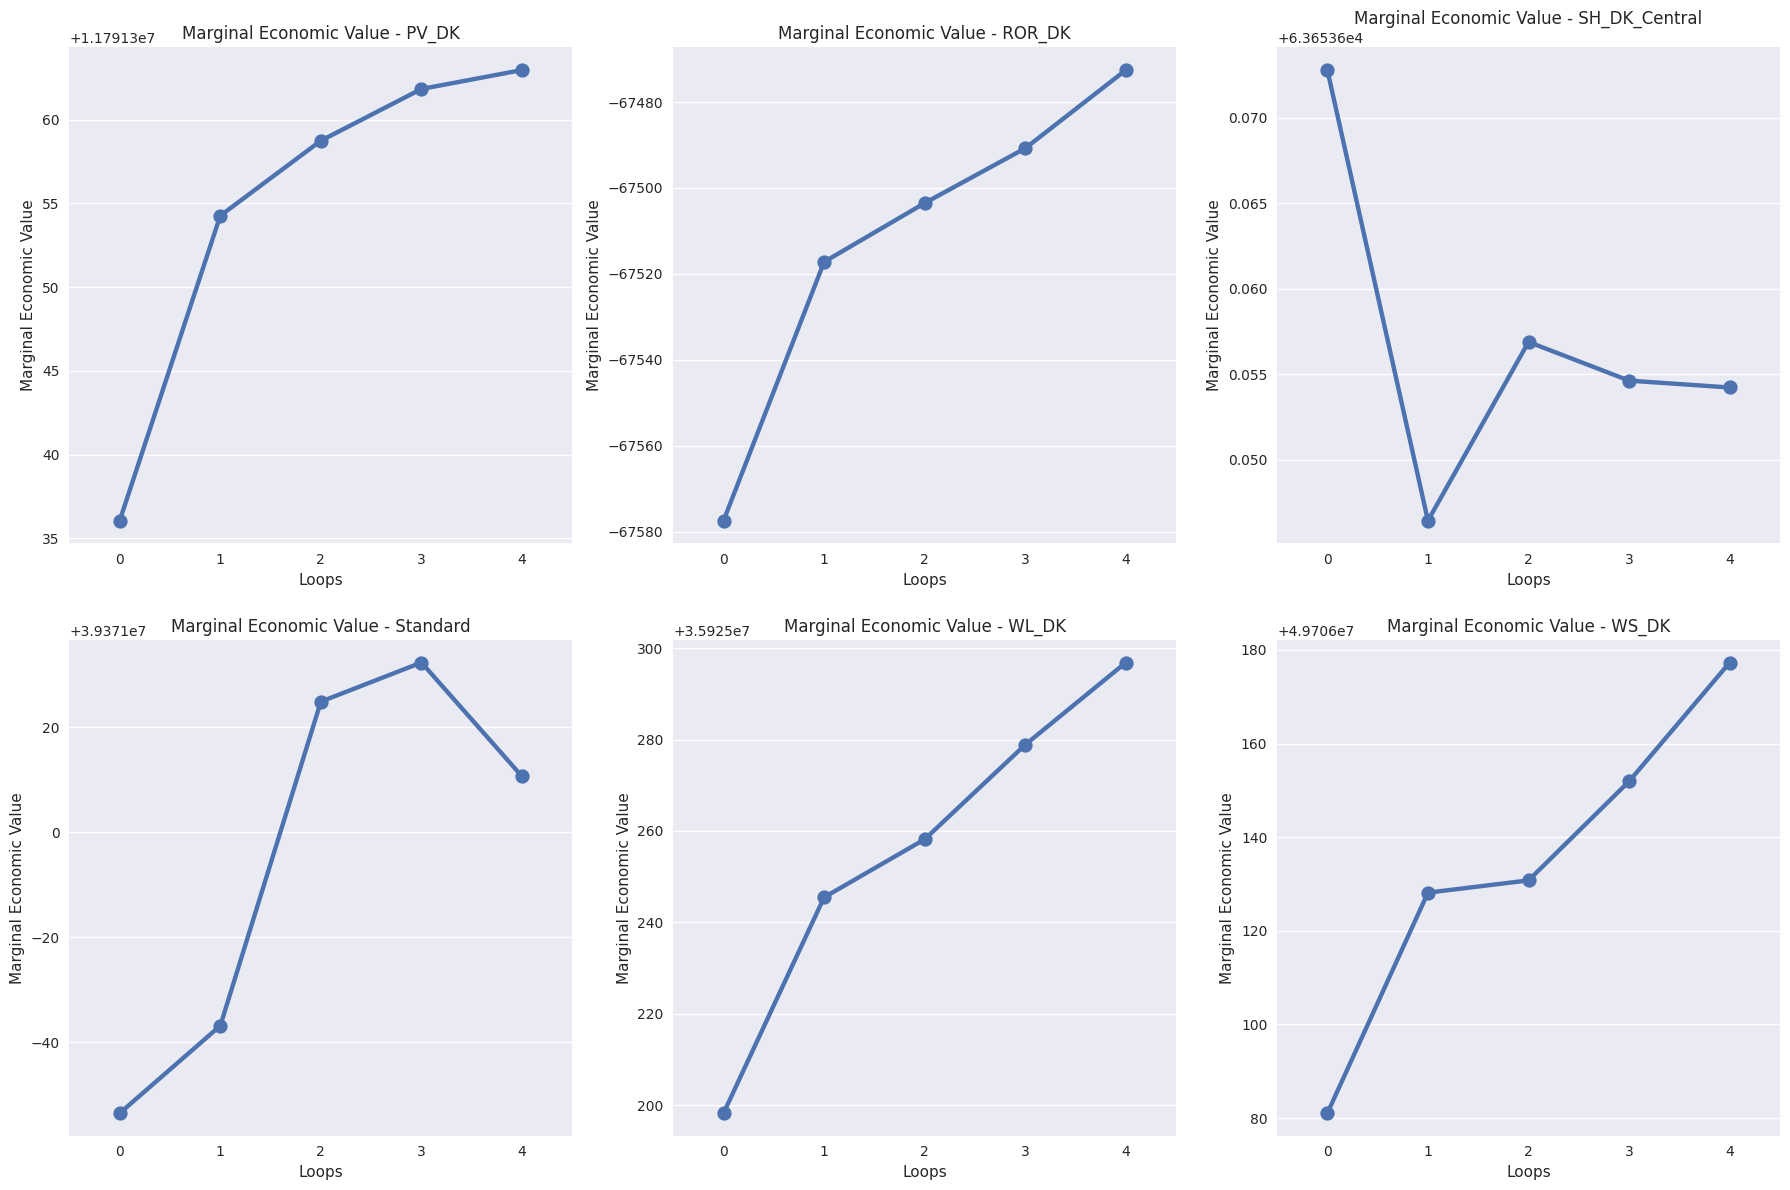

In [68]:
# Unique 'hvt' values
hvt_values = marginalEconomicValue_df_loop_mean_long['hvt'].unique()

# Create a 2x3 subplot grid
fig, axes = plt.subplots(2, 3, figsize=(18, 12))

# Reshape the axes into a flat list for easy iteration
axes_flat = axes.flatten()

# Loop over each 'hvt' value and plot in a subplot
for i, hvt in enumerate(hvt_values):
    ax = axes_flat[i]
    df_subset = marginalEconomicValue_df_loop_mean_long[marginalEconomicValue_df_loop_mean_long['hvt'] == hvt]
    sns.pointplot(x='Loops', y='Marginal Economic Value positive', hue='hvt', data=df_subset, linestyles='-', dodge=False, ax=ax)
    ax.set_title(f'Marginal Economic Value - {hvt}')
    ax.set_xlabel('Loops')
    ax.set_ylabel('Marginal Economic Value')
    ax.get_legend().remove()  # Remove legend from each subplot

# Hide any remaining empty subplots
for i in range(len(hvt_values), len(axes_flat)):
    fig.delaxes(axes_flat[i])

# Adjust layout
plt.tight_layout()

# Save the figure
plt.savefig('counterfactual_marginalEconomicValue_plot.png')

plt.show()

findfont: Font family 'Palatino Linotype' not found.
findfont: Font family 'Palatino Linotype' not found.
findfont: Font family 'Palatino Linotype' not found.
findfont: Font family 'Palatino Linotype' not found.
findfont: Font family 'Palatino Linotype' not found.
findfont: Font family 'Palatino Linotype' not found.
findfont: Font family 'Palatino Linotype' not found.
findfont: Font family 'Palatino Linotype' not found.
findfont: Font family 'Palatino Linotype' not found.
findfont: Font family 'Palatino Linotype' not found.
findfont: Font family 'Palatino Linotype' not found.
findfont: Font family 'Palatino Linotype' not found.
findfont: Font family 'Palatino Linotype' not found.
findfont: Font family 'Palatino Linotype' not found.
findfont: Font family 'Palatino Linotype' not found.
findfont: Font family 'Palatino Linotype' not found.
findfont: Font family 'Palatino Linotype' not found.
findfont: Font family 'Palatino Linotype' not found.
findfont: Font family 'Palatino Linotype' not 

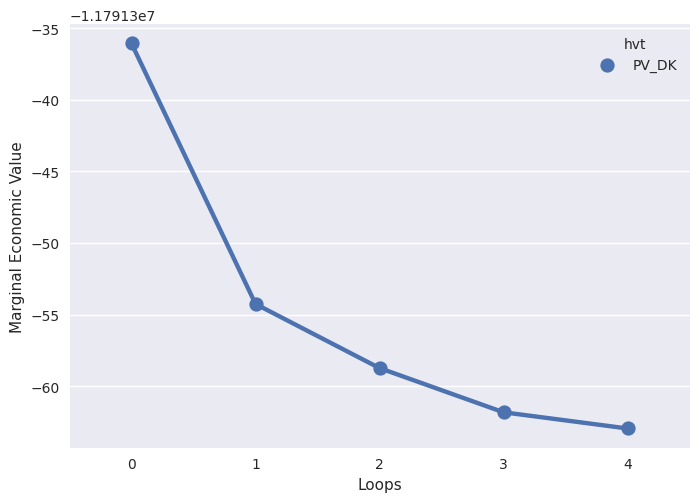

In [69]:
marginalEconomicValue_df_loop_mean_long_PV_DK = marginalEconomicValue_df_loop_mean_long[marginalEconomicValue_df_loop_mean_long['hvt'] == 'PV_DK']

# Plot
sns.pointplot(x='Loops', y='Marginal Economic Value', hue='hvt', data=marginalEconomicValue_df_loop_mean_long_PV_DK, linestyles='-', dodge=False)
#plt.title('Marginal Economic Value for Pholtovotaics')
plt.show()

findfont: Font family 'Palatino Linotype' not found.
findfont: Font family 'Palatino Linotype' not found.
findfont: Font family 'Palatino Linotype' not found.
findfont: Font family 'Palatino Linotype' not found.
findfont: Font family 'Palatino Linotype' not found.
findfont: Font family 'Palatino Linotype' not found.
findfont: Font family 'Palatino Linotype' not found.
findfont: Font family 'Palatino Linotype' not found.
findfont: Font family 'Palatino Linotype' not found.
findfont: Font family 'Palatino Linotype' not found.
findfont: Font family 'Palatino Linotype' not found.
findfont: Font family 'Palatino Linotype' not found.
findfont: Font family 'Palatino Linotype' not found.
findfont: Font family 'Palatino Linotype' not found.
findfont: Font family 'Palatino Linotype' not found.
findfont: Font family 'Palatino Linotype' not found.
findfont: Font family 'Palatino Linotype' not found.
findfont: Font family 'Palatino Linotype' not found.
findfont: Font family 'Palatino Linotype' not 

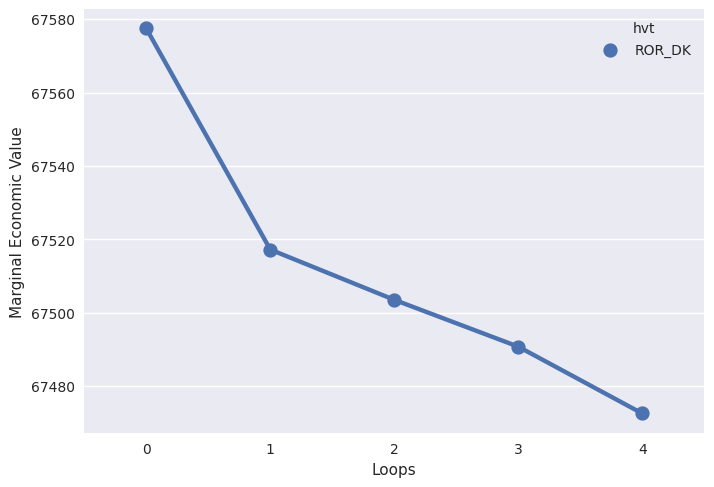

In [70]:
marginalEconomicValue_df_loop_mean_long_PV_DK = marginalEconomicValue_df_loop_mean_long[marginalEconomicValue_df_loop_mean_long['hvt'] == 'ROR_DK']

# Plot
sns.pointplot(x='Loops', y='Marginal Economic Value', hue='hvt', data=marginalEconomicValue_df_loop_mean_long_PV_DK, linestyles='-', dodge=False)
#plt.title('Marginal Economic Value for Pholtovotaics')
plt.show()

findfont: Font family 'Palatino Linotype' not found.
findfont: Font family 'Palatino Linotype' not found.
findfont: Font family 'Palatino Linotype' not found.
findfont: Font family 'Palatino Linotype' not found.
findfont: Font family 'Palatino Linotype' not found.
findfont: Font family 'Palatino Linotype' not found.
findfont: Font family 'Palatino Linotype' not found.
findfont: Font family 'Palatino Linotype' not found.
findfont: Font family 'Palatino Linotype' not found.
findfont: Font family 'Palatino Linotype' not found.
findfont: Font family 'Palatino Linotype' not found.
findfont: Font family 'Palatino Linotype' not found.
findfont: Font family 'Palatino Linotype' not found.
findfont: Font family 'Palatino Linotype' not found.
findfont: Font family 'Palatino Linotype' not found.
findfont: Font family 'Palatino Linotype' not found.
findfont: Font family 'Palatino Linotype' not found.
findfont: Font family 'Palatino Linotype' not found.
findfont: Font family 'Palatino Linotype' not 

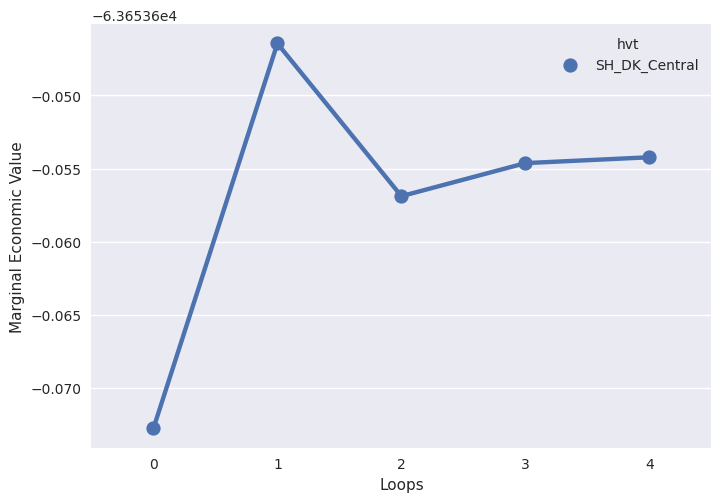

In [71]:
marginalEconomicValue_df_loop_mean_long_PV_DK = marginalEconomicValue_df_loop_mean_long[marginalEconomicValue_df_loop_mean_long['hvt'] == 'SH_DK_Central']

# Plot
sns.pointplot(x='Loops', y='Marginal Economic Value', hue='hvt', data=marginalEconomicValue_df_loop_mean_long_PV_DK, linestyles='-', dodge=False)
#plt.title('Marginal Economic Value for Pholtovotaics')
plt.show()

findfont: Font family 'Palatino Linotype' not found.
findfont: Font family 'Palatino Linotype' not found.
findfont: Font family 'Palatino Linotype' not found.
findfont: Font family 'Palatino Linotype' not found.
findfont: Font family 'Palatino Linotype' not found.
findfont: Font family 'Palatino Linotype' not found.
findfont: Font family 'Palatino Linotype' not found.
findfont: Font family 'Palatino Linotype' not found.
findfont: Font family 'Palatino Linotype' not found.
findfont: Font family 'Palatino Linotype' not found.
findfont: Font family 'Palatino Linotype' not found.
findfont: Font family 'Palatino Linotype' not found.
findfont: Font family 'Palatino Linotype' not found.
findfont: Font family 'Palatino Linotype' not found.
findfont: Font family 'Palatino Linotype' not found.
findfont: Font family 'Palatino Linotype' not found.
findfont: Font family 'Palatino Linotype' not found.
findfont: Font family 'Palatino Linotype' not found.
findfont: Font family 'Palatino Linotype' not 

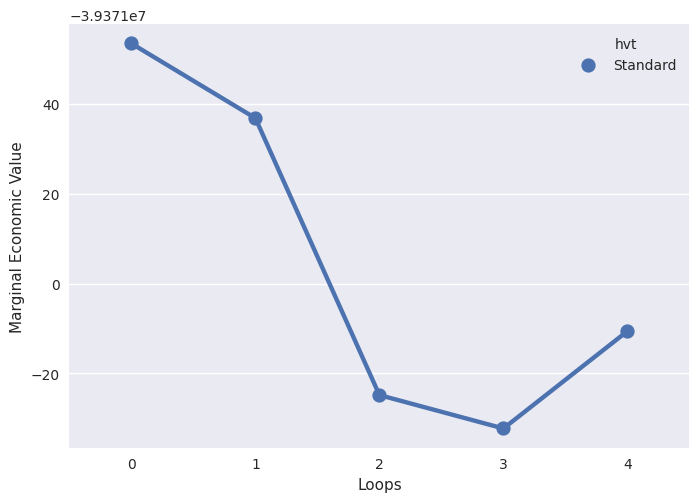

In [72]:
marginalEconomicValue_df_loop_mean_long_PV_DK = marginalEconomicValue_df_loop_mean_long[marginalEconomicValue_df_loop_mean_long['hvt'] == 'Standard']

# Plot
sns.pointplot(x='Loops', y='Marginal Economic Value', hue='hvt', data=marginalEconomicValue_df_loop_mean_long_PV_DK, linestyles='-', dodge=False)
#plt.title('Marginal Economic Value for Pholtovotaics')
plt.show()

findfont: Font family 'Palatino Linotype' not found.
findfont: Font family 'Palatino Linotype' not found.
findfont: Font family 'Palatino Linotype' not found.
findfont: Font family 'Palatino Linotype' not found.
findfont: Font family 'Palatino Linotype' not found.
findfont: Font family 'Palatino Linotype' not found.
findfont: Font family 'Palatino Linotype' not found.
findfont: Font family 'Palatino Linotype' not found.
findfont: Font family 'Palatino Linotype' not found.
findfont: Font family 'Palatino Linotype' not found.
findfont: Font family 'Palatino Linotype' not found.
findfont: Font family 'Palatino Linotype' not found.
findfont: Font family 'Palatino Linotype' not found.
findfont: Font family 'Palatino Linotype' not found.
findfont: Font family 'Palatino Linotype' not found.
findfont: Font family 'Palatino Linotype' not found.
findfont: Font family 'Palatino Linotype' not found.
findfont: Font family 'Palatino Linotype' not found.
findfont: Font family 'Palatino Linotype' not 

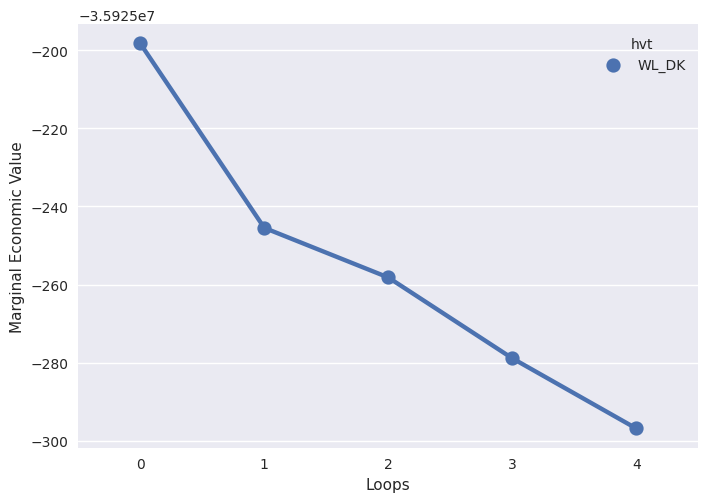

In [73]:
marginalEconomicValue_df_loop_mean_long_PV_DK = marginalEconomicValue_df_loop_mean_long[marginalEconomicValue_df_loop_mean_long['hvt'] == 'WL_DK']

# Plot
sns.pointplot(x='Loops', y='Marginal Economic Value', hue='hvt', data=marginalEconomicValue_df_loop_mean_long_PV_DK, linestyles='-', dodge=False)
#plt.title('Marginal Economic Value for Pholtovotaics')
plt.show()

findfont: Font family 'Palatino Linotype' not found.
findfont: Font family 'Palatino Linotype' not found.
findfont: Font family 'Palatino Linotype' not found.
findfont: Font family 'Palatino Linotype' not found.
findfont: Font family 'Palatino Linotype' not found.
findfont: Font family 'Palatino Linotype' not found.
findfont: Font family 'Palatino Linotype' not found.
findfont: Font family 'Palatino Linotype' not found.
findfont: Font family 'Palatino Linotype' not found.
findfont: Font family 'Palatino Linotype' not found.
findfont: Font family 'Palatino Linotype' not found.
findfont: Font family 'Palatino Linotype' not found.
findfont: Font family 'Palatino Linotype' not found.
findfont: Font family 'Palatino Linotype' not found.
findfont: Font family 'Palatino Linotype' not found.
findfont: Font family 'Palatino Linotype' not found.
findfont: Font family 'Palatino Linotype' not found.
findfont: Font family 'Palatino Linotype' not found.
findfont: Font family 'Palatino Linotype' not 

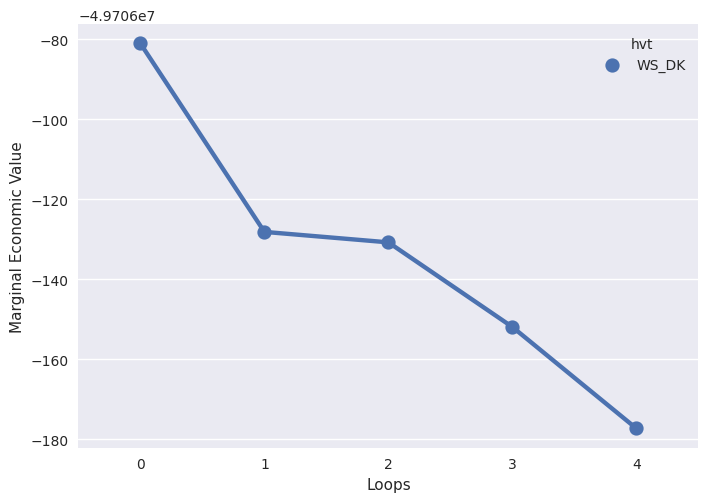

In [74]:
marginalEconomicValue_df_loop_mean_long_PV_DK = marginalEconomicValue_df_loop_mean_long[marginalEconomicValue_df_loop_mean_long['hvt'] == 'WS_DK']

# Plot
sns.pointplot(x='Loops', y='Marginal Economic Value', hue='hvt', data=marginalEconomicValue_df_loop_mean_long_PV_DK, linestyles='-', dodge=False)
#plt.title('Marginal Economic Value for Pholtovotaics')
plt.show()